In [1]:
!pip3 install beautifulsoup4 --user
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install pyproj==1.9.6 --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [1]:
import os
import re
import multiprocessing
import datetime
from datetime import date, timedelta

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

## Fetch observations

In [2]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None

def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations

def get_stations_with_coords():
    soup = fetch('http://weather.rap.ucar.edu/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*[\s]([\d]+\s[\d]+\w).*[\s]([\d]+\s[\d]+\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0], 'coords': "+".join(match[1:]).replace(' ', '-')})
    return stations

def gms_to_lat_lng(gms):
    comp = gms.split('-')
    if len(comp)==2:
        if 'N' in comp[1] or 'E' in comp[1]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)
        else:
            return -(int(comp[0])+(int(comp[1][:len(comp)])/60))
    elif len(comp)==3:
        if 'N' in comp[2] or 'E' in comp[2]:
            return int(comp[0])+(int(comp[1][:len(comp)])/60)+(int(comp[2][:len(comp)-1])/60)
        else:
            comp[2]='0'+comp[2][:len(comp)-1]
            return (-int(comp[0])-(int(comp[1][:len(comp)])/60)-(int(comp[2][:len(comp)-1])/3600))
    else:
        return 0

def get_last_metar(station):
    now = datetime.datetime.utcnow()
    soup = fetch(f"https://www.ogimet.com/display_metars2.php?lugar={station['ICAO']}&tipo=SA&ord=REV&nil=SI&fmt=txt&ano={now.year}&mes={now.month}&day={now.day}&hora={now.hour}&enviar=Ver")
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de {station} en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', ' ', text)
    matches = re.findall(r"(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            (lat, lng, elev) = station['coords'].split('+')
            data.append({ 'lat': gms_to_lat_lng(lat), 'lng': gms_to_lat_lng(lng), 'elev': elev, 'datetime': match[0], 'observation': match[1] })
    return data

## Parse data from METAR

In [3]:
PRESSURE_LEVELS_HEIGHTS_VALUES = [
    762,
    1458,
    3013,
    5576,
    9166,
    11787,
    16000,
]

def get_pressure(obs):
    """returns press Pa
    
    format examples:
        pressure: 1027.8 mb
        3-hr pressure change 1.7hPa, increasing, then decreasing
    """

    press = 0.0
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0])
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0])

    return press * 100

def get_dew_point(obs):
    """ returns temp K """
    return float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def get_temperature(obs):
    """ returns temp K """
    return float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)

def get_wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+)[\s|\w]*[\s]([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        # print(f"get_wind_comps, compass_point:{compass_point} mag:{mag}\n")
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)

def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_HEIGHTS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level

## Physical formulas

In [31]:
def vapor_pressure(T):
    """Return partial water vapor pressure (e) or saturation vapor pressure (es) hPa.
    
    dew_point for (e) K
    temperature for (es) K
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    alternatives: August–Roche–Magnus formula
    """
    a = 17.2693882
    b = 35.86
    e = 6.1078 * np.exp(a * (T - 273.16) / (T - b))
    
    return e

def calculate_shum(dew_point, pressure):
    """Return specific humidity kg/kg.
    
    dew_point K
    pressure  Pa
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    """
    e = vapor_pressure(dew_point)
    q = 0.622 * e  / (pressure - 0.378 * e)
    
    #print(dew_point, pressure, q)    
    return q

def calculate_rhum(dew_point, temp):
    """ validator: https://www.wpc.ncep.noaa.gov/html/dewrh.shtml """
    rhum = 100 * vapor_pressure(dew_point) / vapor_pressure(temp)

    #print(dew_point, temp, rhum)
    return rhum

In [5]:
noaa_stations = get_stations_with_coords()
print(len(noaa_stations))

9580


In [6]:
line = 'KHRL 112152Z 10011KT 10SM FEW036 BKN060 28/21 A2984 RMK AO2 SLP105 T02780206'
obs = Metar.Metar(line).string()
print(obs)

dew_point = get_dew_point(obs)
temp = get_temperature(obs)
press = get_pressure(obs)
(u, v) = get_wind_comps(obs)

calculate_rhum(dew_point, temp)
calculate_shum(dew_point, press)

station: KHRL
type: routine report, cycle 22 (automatic report)
time: Wed Nov 11 21:52:00 2020
temperature: 27.8 C
dew point: 20.6 C
wind: E at 11 knots
visibility: 10 miles
pressure: 1010.5 mb
sky: a few clouds at 3600 feet
     broken clouds at 6000 feet
sea-level pressure: 1010.5 mb
remarks:
- Automated station (type 2)
METAR: KHRL 112152Z 10011KT 10SM FEW036 BKN060 28/21 A2984 RMK AO2 SLP105 T02780206


1.492725956726276e-07

In [7]:
def fetch_last_metars(station):
    localdata = []
    metar_obs = get_last_metar(station)
    for obs_item in metar_obs:
        hour = datetime.datetime.strptime(obs_item['datetime'], '%Y%m%d%H%M').hour
        if hour == 0 or hour == 6 or hour == 12 or hour == 18:
            localdata.append([obs_item['lat'], obs_item['lng'], obs_item['elev'], obs_item['datetime'], obs_item['observation']])
    return localdata

In [8]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(fetch_last_metars, noaa_stations)
    
df = []
for elem in data:
    for arr in elem:
        df.append(arr)

len(df)

In [10]:
df = pd.DataFrame(data=df, columns=['lat', 'lng', 'elev', 'datetime', 'observation'])
df.head(5)

,lat,lng,elev,datetime,observation
0,54.150000,-165.600000,25,202011121235,PAUT 121235Z AUTO 30023G31KT 10SM SCT040 BKN04...
1,54.150000,-165.600000,25,202011121215,PAUT 121215Z AUTO 28025G32KT 10SM SCT041 BKN04...
2,66.566667,-145.266667,131,202011121200,PAFY NIL
3,58.366667,-134.583333,5,202011121200,PAJN NIL
4,61.866667,-162.033333,31,202011121202,PADM 121202Z AUTO 00000KT 10SM OVC060 M01/M02 ...


In [11]:
idx = 0
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)
print(row['lat'], row['lng'], row['elev'])

station: PAUT
type: routine report, cycle 12 (automatic report)
time: Thu Nov 12 12:35:00 2020
temperature: 4.2 C
dew point: -1.4 C
wind: WNW at 23 knots, gusting to 31 knots
visibility: 10 miles
pressure: 1009.8 mb
sky: scattered clouds at 4000 feet
     broken clouds at 4700 feet
     broken clouds at 6500 feet
remarks:
- Automated station (type 2)
- PWINO
METAR: PAUT 121235Z AUTO 30023G31KT 10SM SCT040 BKN047 BKN065 04/M01 A2982 RMK AO2 T00421014 PWINO
54.15 -165.6 25


In [12]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.sort_values(by='datetime')

df.head()

,lat,lng,elev,datetime,observation
5518,-10.050000,-161.083333,5,2020-11-12 12:00:00,NCRK 121200Z AUTO 01003KT //// ////// 26/24 Q1011
2213,4.416667,-75.150000,928,2020-11-12 12:00:00,SKIB NIL
2214,0.883333,-77.666667,2961,2020-11-12 12:00:00,SKIP NIL
2215,7.816667,-76.700000,30,2020-11-12 12:00:00,SKLC NIL
2216,-4.200000,-69.933333,84,2020-11-12 12:00:00,SKLT 121200Z 00000KT 9999 SCT013 BKN080 25/25 ...


In [33]:
def parse_metars(idx):
    dt = []
    cords = []
    row = df.iloc[idx]
    try:
        temp = 0.0
        obs = Metar.Metar(row['observation']).string()
        if ('temperature' in obs):
            temp = get_temperature(obs)
            #if temp < 331.15:
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'air', temp])

        (u, v) = get_wind_comps(obs)
        if (u, v) != (0,0):
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'uwnd', u])
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'vwnd', v])

        # pA
        if ('pressure' in obs):
            press = get_pressure(obs)
            #if press < 1051 and press > 522:
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'press', press])

        if ('dew point' in obs and 'pressure' in obs):
            dew_point = get_dew_point(obs)
            #if dew_point > 0 and press < 1050 and press > 522 and dew_point <= temp and temp != 0 :
            shum = calculate_shum(dew_point, press)
            rhum = calculate_rhum(dew_point, temp)
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'rhum', rhum])
            #if shum < 0.05:
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), row['lat'], row['lng'], row['elev'], 'shum', shum])

        cords.append((row['lat'], row['lng']))
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)
    return (dt, cords)

In [34]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(df)))
    
df_parsed_metars = []
active_stations = []
for elem in data:
    df_parsed_metars += elem[0]
    for cords in elem[1]:
        if (cords not in active_stations):
            active_stations.append(cords)

print(f"total metars:{len(df_parsed_metars)},active stations: {len(active_stations)}")

In [38]:
df_metar_info = pd.DataFrame(df_parsed_metars,columns=['datetime','lat','lng','elev','variable','value'])

df_metar_info.head(10)

,datetime,lat,lng,elev,variable,value
0,2020-11-12 12:00:00,-10.05,-161.083333,5,air,299.150000
1,2020-11-12 12:00:00,-10.05,-161.083333,5,uwnd,0.000000
2,2020-11-12 12:00:00,-10.05,-161.083333,5,vwnd,1.543210
3,2020-11-12 12:00:00,-10.05,-161.083333,5,press,101100.000000
4,2020-11-12 12:00:00,-10.05,-161.083333,5,rhum,88.768597
5,2020-11-12 12:00:00,-10.05,-161.083333,5,shum,0.000183
6,2020-11-12 12:00:00,-4.20,-69.933333,84,air,298.150000
7,2020-11-12 12:00:00,-4.20,-69.933333,84,press,101190.000000
8,2020-11-12 12:00:00,-4.20,-69.933333,84,rhum,100.000000
9,2020-11-12 12:00:00,-4.20,-69.933333,84,shum,0.000195


In [40]:
all_df_datetimes = []

for df_datetime in df_metar_info.datetime.unique():
    parsed_datetime = datetime.datetime.strptime(df_datetime, '%Y-%m-%d %H:%M:%S')
    if parsed_datetime.minute == 0:
        all_df_datetimes.append(parsed_datetime)

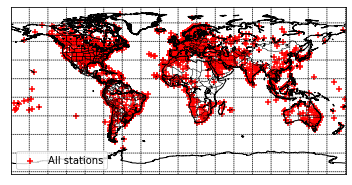

In [41]:
Show_df=df_metar_info.loc[df_metar_info['variable']=='shum'].loc[df_metar_info['value']<50]
lataux=[]
lngaux=[]
for reg in Show_df.values:
    if reg[1] not in lataux and reg[2] not in lngaux:
        lataux.append(reg[1])
        lngaux.append(reg[2])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngaux,
    lataux,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('all_stations.jpg', dpi=600)
plt.show()


count    4156.000000
mean        0.000074
std         0.000051
min         0.000002
25%         0.000035
50%         0.000061
75%         0.000104
max         0.000343
Name: value, dtype: float64

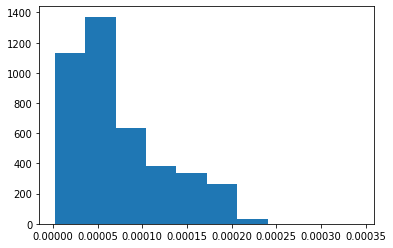

In [42]:
data = df_metar_info.loc[df_metar_info['variable']=='shum']['value']
plt.hist(data)
data.describe()

count    4156.000000
mean       77.635036
std        18.791630
min         5.328022
25%        67.320061
50%        81.034240
75%        93.079160
max       107.649448
Name: value, dtype: float64

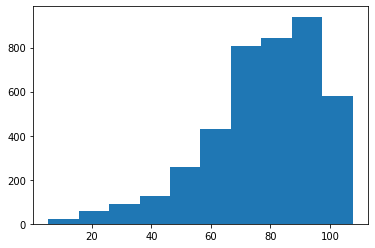

In [43]:
data = df_metar_info.loc[df_metar_info['variable']=='rhum']['value']
plt.hist(data)
data.describe()

count      4214.000000
mean     101657.441860
std        2177.760737
min         140.000000
25%      101390.000000
50%      101700.000000
75%      102100.000000
max      103800.000000
Name: value, dtype: float64

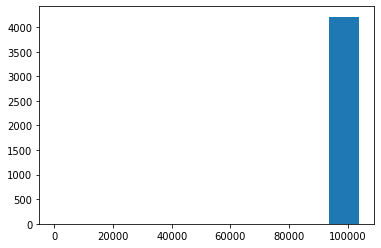

In [44]:
data = df_metar_info.loc[df_metar_info['variable']=='press']['value']
plt.hist(data)
data.describe()

count    4205.000000
mean      284.335660
std        11.673885
min       241.150000
25%       275.150000
50%       285.150000
75%       294.150000
max       311.150000
Name: value, dtype: float64

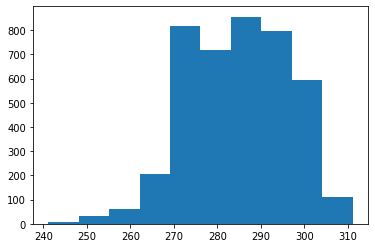

In [45]:
data = df_metar_info.loc[df_metar_info['variable']=='air']['value']
plt.hist(data)
data.describe()

count    3250.000000
mean       -0.165036
std         2.964369
min       -14.831760
25%        -2.004833
50%         0.000000
75%         1.628877
max        16.095619
Name: value, dtype: float64

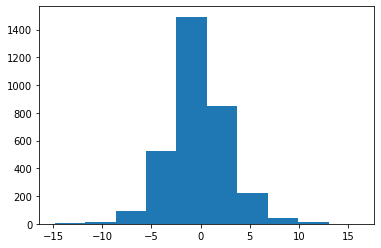

In [46]:
data = df_metar_info.loc[df_metar_info['variable']=='uwnd']['value']
plt.hist(data)
data.describe()

count    3250.000000
mean        0.113641
std         3.041558
min       -15.884117
25%        -1.847099
50%        -0.091003
75%         2.057613
max        15.191079
Name: value, dtype: float64

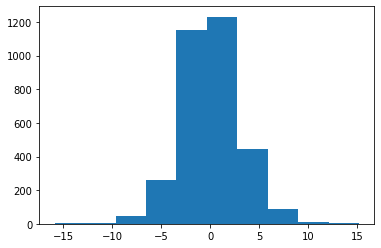

In [47]:
data = df_metar_info.loc[df_metar_info['variable']=='vwnd']['value']
plt.hist(data)
data.describe()

In [48]:
def create_csv(file_datetime):
    filename = "last/{}.csv".format(file_datetime.strftime('%Y%m%d%H'))
    df_file = df_metar_info.loc[df_metar_info['datetime'].str.contains(file_datetime.strftime('%Y-%m-%d %H'))]
    df_file.to_csv(filename, index=False)

In [49]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(create_csv, all_df_datetimes)